In [3]:
import pandas as pd
import numpy as np
import lightkurve as lk
from astropy import units as u


def download(tic):
    name = f"TIC {tic}"

    search_result = lk.search_lightcurve(name, author="SPOC", exptime=120)

    # data
    klc = search_result[0].download()
    times = klc.time.to_value("mjd")
    fluxes = klc.pdcsap_flux.to_value().filled(np.nan)
    errors = klc.flux_err.to_value().filled(np.nan)
    mask = np.isnan(fluxes) | np.isnan(errors) | np.isnan(times)
    original_time = times[~mask]
    original_flux = fluxes[~mask]
    original_error = errors[~mask]

    splits = np.array_split(
        np.arange(len(original_time)), np.flatnonzero(np.diff(original_time) > 0.1) + 1
    )

    n = 300
    time = np.hstack([original_time[split[n:-n]] for split in splits])
    flux = np.hstack([original_flux[split[n:-n]] for split in splits])
    error = np.hstack([original_error[split[n:-n]] for split in splits])

    flux_median = np.median(original_flux)
    time = time - original_time[0]
    flux /= flux_median
    error /= flux_median

    url = f"https://exofop.ipac.caltech.edu/tess/download_stellar.php?id={tic}"
    star = pd.read_csv(url, delimiter="|", index_col=1).iloc[0]

    return {
        "flux": flux,
        "time": time,
        "error": error,
        "teff": star["Teff (K)"],
        "star_radius": star["Radius (R_Sun)"],
        "star_mass": star["Mass (M_Sun)"],
        "sectors": klc.sector,
        "original_flux": original_flux / flux_median,
        "original_error": original_error,
        "original_time": original_time - original_time[0],
    }

/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/lgrcia/.lightkurve/cache. Please move all the files in the legacy directory /Users/lgrcia/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [22]:
import pandas as pd

tess_400_targets = pd.read_csv("../data/tess-ultra-fast-rotators-brighter-mag14.csv")
tess_400_targets = tess_400_targets.sort_values("LS_Period")


TIC 153193474
Teff: 3351.000 K
Sectors: 7


(0.0, 5.0)

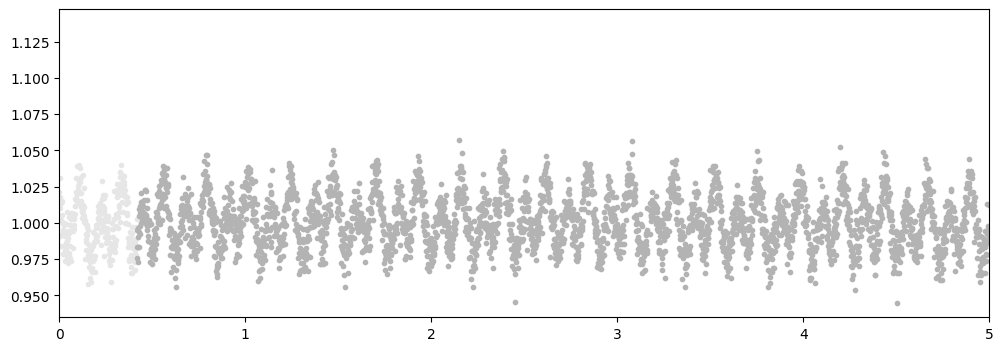

: 

In [27]:
import matplotlib.pyplot as plt

# 1 ok
tic = int(tess_400_targets.iloc[4].Name)

data = download(tic)
mask = np.abs(data["flux"] - np.median(data["flux"])) < 4 * np.std(data["flux"])
data["time"] = data["time"][mask]
data["flux"] = data["flux"][mask]
data["error"] = data["error"][mask]

plt.figure(figsize=(12, 4))
plt.plot(data["original_time"], data["original_flux"], ".", color="0.9")
plt.plot(data["time"], data["flux"], ".", color="0.7")
print(f"TIC {tic}")
print(f"Teff: {data['teff']:.3f} K")
print(f"Sectors: {data['sectors']}")
plt.xlim(0, 5)


In [18]:
tic


63907355

False positive probability: 1.29e-272
Period: 0.971 days


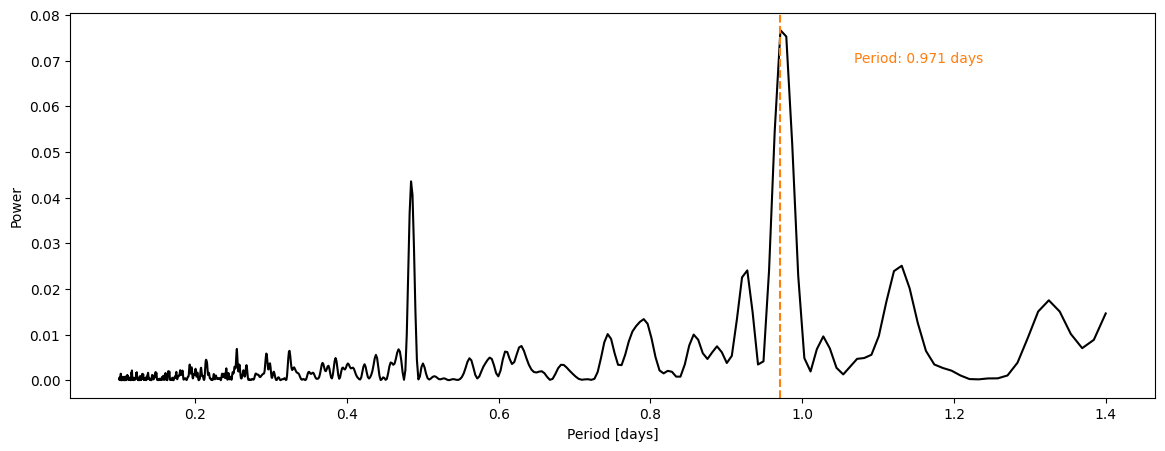

In [97]:
# lomb scargle periodogram
from astropy.timeseries import LombScargle

LS = LombScargle(data["time"], data["flux"], data["error"])
frequency, power = LS.autopower(minimum_frequency=1 / 1.4, maximum_frequency=10)
plt.figure(figsize=(14, 5))
plt.plot(1 / frequency, power, "k")
plt.xlabel("Period [days]")
plt.ylabel("Power")

# Compute the false positive probability of the found period
fp_prob = LS.false_alarm_probability(
    power.max(), minimum_frequency=1 / 3, maximum_frequency=2 * np.pi / 1.5
)
print(f"False positive probability: {fp_prob:.2e}")


#  Plot and print the period of the highest peak
period = 1 / frequency[np.argmax(power)]
print(f"Period: {period:.3f} days")
plt.axvline(period, color="C1", linestyle="dashed")
_ = plt.text(
    period * 1.1,
    0.9 * power.max(),
    f"Period: {period:.3f} days",
    ha="left",
    va="bottom",
    color="C1",
)